# Example notebook to show how the new chemical mixture creator works

In [10]:
import os
import sys
from pathlib import Path

In [11]:
vimms_path = '/Users/simon/git/vimms'
sys.path.append(vimms_path)
# path to fixtures so we can load HMDB
BASE_DIR = os.path.abspath(Path(vimms_path,'tests','integration', 'fixtures'))

In [28]:
%load_ext autoreload
%autoreload 2

from vimms.Common import *
from vimms.Controller import AIF
from vimms.Environment import Environment
from vimms.MassSpec import IndependentMassSpectrometer

# Noise for the MS
from vimms.Noise import GaussianPeakNoise,  UniformSpikeNoise

# Chemical creator import
from vimms.Chemicals import ChemicalMixtureCreator
from vimms.ChemicalSamplers import UniformRTAndIntensitySampler, UniformMS2Sampler, CRPMS2Sampler, GaussianChromatogramSampler, DatabaseFormulaSampler, UniformMZFormulaSampler




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load HMDB

In [20]:
HMDB = load_obj(Path(BASE_DIR, 'hmdb_compounds.p'))

In [29]:
N_CHEMS = 10
MZ_RANGE = [(0, 1050)]
RT_RANGE = [(300, 500)]

In [41]:
# sample RT and log intensity uniformly. See class def for min and max log intensity
# returns actual intensity, but samples in log space
uu = UniformRTAndIntensitySampler(min_rt = 300, max_rt = 500)

# a sampler that samples MS2 uniform between 50 and the mass of the formula.
# number ofo MS2 peaks is poisson with mean poiss_peak_mean
us = UniformMS2Sampler(poiss_peak_mean=5)

# OR a CRP MS2 sampler
us = CRPMS2Sampler()

# generates Gaussian chromatograms
cs = GaussianChromatogramSampler()

# generates formulas from HMDB
hf = DatabaseFormulaSampler(HMDB)

hf = UniformMZFormulaSampler()

# The chemical mixture creator object

cm = ChemicalMixtureCreator(hf, rt_and_intensity_sampler=uu, 
                            adduct_prior_dict=ADDUCT_DICT_POS_MH,
                            chromatogram_sampler=cs,
                            ms2_sampler = us)

d = cm.sample(MZ_RANGE,RT_RANGE,N_CHEMS,2)

TypeError: isinstance() arg 2 must be a type or tuple of types

Print the sampled chemicals, and their children

In [24]:
d.sort(key=lambda x: x.rt)
for chem in d:
    print(chem)
    for child in chem.children:
        print('\t',child)

KnownChemical - 'C39H47N5O5' rt=302.28 max_intensity=747000.03
	 MSN Fragment mz=148.5030 ms_level=2
	 MSN Fragment mz=296.5924 ms_level=2
	 MSN Fragment mz=429.7184 ms_level=2
	 MSN Fragment mz=488.3322 ms_level=2
	 MSN Fragment mz=591.4519 ms_level=2
	 MSN Fragment mz=619.0704 ms_level=2
KnownChemical - 'C43H78O5' rt=308.07 max_intensity=744866.57
	 MSN Fragment mz=151.2526 ms_level=2
	 MSN Fragment mz=368.8561 ms_level=2
	 MSN Fragment mz=477.6754 ms_level=2
	 MSN Fragment mz=568.7815 ms_level=2
	 MSN Fragment mz=632.9913 ms_level=2
KnownChemical - 'C30H48O2' rt=343.78 max_intensity=1647865.15
	 MSN Fragment mz=51.8405 ms_level=2
	 MSN Fragment mz=129.4820 ms_level=2
	 MSN Fragment mz=162.4652 ms_level=2
	 MSN Fragment mz=219.3370 ms_level=2
	 MSN Fragment mz=235.9387 ms_level=2
	 MSN Fragment mz=339.6910 ms_level=2
	 MSN Fragment mz=430.3538 ms_level=2
KnownChemical - 'C28H38O13' rt=347.21 max_intensity=7685937.64
	 MSN Fragment mz=208.0096 ms_level=2
	 MSN Fragment mz=270.2632 ms_

Create and run an example controller. In this case, AIF.

In [25]:
controller = AIF(MZ_RANGE[0][0],MZ_RANGE[0][1])
ionisation_mode = POSITIVE
scan_time_dict = {1:0.6,2:0.06}


mz_noise = GaussianPeakNoise(0.001)
intensity_noise = GaussianPeakNoise(0.1,log_space=True)

# This is new: spike noise which ensures no scans are empty
# first argument is density: how many spikes to sample per unit m/z. Second is max spike intensity
spike_noise = UniformSpikeNoise(0.01,1e3)


# note the None in the call in place of a peak sampler object - this isn't used anywhere in this example
mass_spec = IndependentMassSpectrometer(ionisation_mode, d, None,
                                        scan_duration_dict = scan_time_dict, 
                                        mz_noise = mz_noise,
                                        intensity_noise = intensity_noise,
                                        spike_noise = spike_noise)


In [26]:
env = Environment(mass_spec, controller, 300, 600, progress_bar=True)

In [27]:
set_log_level_warning()
# run the simulation
env.run()
env.write_mzML('.','test.mzML')

(600.000s) ms_level=1: 100%|█████████▉| 299.99999999999994/300 [00:07<00:00, 38.00it/s] 


# Example using new multi-sample

In [75]:
n_control = 5
n_case = 5
group_list = ['control' for i in range(n_control)] + ['case' for i in range(n_case)]
group_dict = {'case': {'missing_probability':0.0, 'changing_probability':0.9}}
from vimms.Chemicals import MultipleMixtureCreator
from vimms.Noise import GaussianPeakNoise
mmc = MultipleMixtureCreator(d,group_list,group_dict,intensity_noise = GaussianPeakNoise(sigma=0.05,log_space=True))
print(mmc.group_multipliers)
chem_lists = mmc.generate_chemical_lists()

case
control
{'case': {KnownChemical - 'C7H6O' rt=323.60 max_intensity=7702245.43: 2.0856609373408466, KnownChemical - 'C38H72O5' rt=334.92 max_intensity=4252674.08: 1.926187748635194, KnownChemical - 'C7H15N3O2' rt=387.11 max_intensity=13741.42: 1.5277630778057516, KnownChemical - 'C20H38O11' rt=397.28 max_intensity=11464.92: 3.2462958877115655, KnownChemical - 'C15H24O3' rt=407.53 max_intensity=229194.77: 1.1634138911252168, KnownChemical - 'C6H12N2O4S2' rt=416.33 max_intensity=4755875.87: 2.1876134346996587, KnownChemical - 'C16H28O8' rt=420.18 max_intensity=470558.48: 1.9208286963102386, KnownChemical - 'C10H13N3O3' rt=484.29 max_intensity=59737.55: 1.6579801825069636, KnownChemical - 'C29H48O' rt=489.55 max_intensity=109775.90: 1.0, KnownChemical - 'C12H16ClNO' rt=489.66 max_intensity=7272711.45: 1.3554483999640674}, 'control': {KnownChemical - 'C7H6O' rt=323.60 max_intensity=7702245.43: 1.0, KnownChemical - 'C38H72O5' rt=334.92 max_intensity=4252674.08: 1.0, KnownChemical - 'C7H1

Check the chemical lists produced with a heatmap


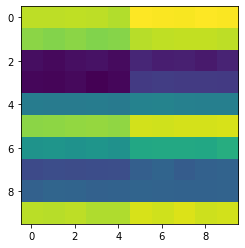

In [78]:
import pylab as plt
%matplotlib inline
intensities = []
for cl in chem_lists:
    new_intensities = [0 for c in d]
    for c in cl:
        c_pos = d.index(c.original_chemical)
        new_intensities[c_pos] = c.max_intensity
    intensities.append(new_intensities)
intensities = np.array(intensities).T
plt.imshow(np.log(intensities+1))